# **Pothole Classification Pipeline — Transformers, CNNs, Ensemble & XAI**

This notebook presents an end-to-end pothole detection pipeline combining **vision transformers**, **convolutional networks**, **cross-validation**, **ensemble learning**, and a structured **explainability framework**.

---

## **Models Used**
All models are ImageNet-pretrained and fine-tuned for binary classification:

- Vision Transformer (ViT-Base)
- Swin Transformer (Swin-Tiny)
- EfficientNet-B0
- ResNet50

Model diversity enables:
- **Transformers** → global context and structure
- **CNNs** → local textures, cracks, and surface patterns

---

## **Pipeline Overview**
- Dataset loading, preprocessing, and augmentation
- CNN- and ViT-compatible Albumentations pipeline
- Mixed-precision training (AMP)
- Cosine learning-rate scheduling with warmup
- Selective layer freezing for CNN fine-tuning
- Individual model training and evaluation
- K-Fold cross-validation across all architectures
- Weighted ensemble for improved robustness

### **Evaluation Metrics**
- Accuracy
- F1-score
- Confusion matrix
- ROC–AUC
- Precision–Recall (Average Precision)

---

## **Explainability (XAI)**
A multi-method interpretability suite to analyze model decisions:

- **Grad-CAM (EfficientNet, ResNet50)**  
  Visualizes spatial activations responsible for pothole predictions.

- **SHAP (ViT)**  
  Pixel-level attribution using KernelExplainer.

- **LIME (ViT)**  
  Superpixel-based local explanations.

- **t-SNE Embeddings**  
  2D visualization of latent feature separability between classes.

---

## **Objective**
To build a **robust, interpretable pothole detection system** by integrating:
- complementary vision architectures
- cross-validated training
- ensemble inference
- transparent model explanations

The pipeline emphasizes both **performance** and **trustworthiness**.

## 1. Install Required Libraries
We install all necessary libraries: PyTorch, timm, albumentations, SHAP, LIME, Captum, UMAP, etc.
This ensures the entire ViT-first pipeline runs in Google Colab.

In [ ]:
!pip install -q kaggle torch torchvision torchaudio timm albumentations opencv-python \
    matplotlib seaborn scikit-learn pandas tqdm lightning transformers \
    captum shap lime umap-learn

## 2. Upload kaggle.json  
Since we are in Colab, we manually upload kaggle.json so the Kaggle API can download the dataset automatically.

In [ ]:
from google.colab import files
uploaded = files.upload()

import os, shutil
os.makedirs("/root/.kaggle", exist_ok=True)

if "kaggle.json" in uploaded:
    shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
else:
    raise ValueError("Please upload kaggle.json")

os.chmod("/root/.kaggle/kaggle.json", 0o600)

print("Kaggle API configured successfully!")

Saving kaggle.json to kaggle.json
Kaggle API configured successfully!


## 3. Download Dataset from Kaggle  
We now download the pothole detection dataset and extract it into `data/raw/`.

In [ ]:
!mkdir -p data/raw
!kaggle datasets download -d atulyakumar98/pothole-detection-dataset -p data/raw --unzip
print("Dataset downloaded.")

Dataset URL: https://www.kaggle.com/datasets/atulyakumar98/pothole-detection-dataset
License(s): CC0-1.0
 54% 105M/194M [00:00<00:00, 1.09GB/s]
100% 194M/194M [00:00<00:00, 580MB/s] 
Dataset downloaded.


## 4. Prepare Directory Structure  
The downloaded dataset uses `Plain/` and `Potholes/`.  
We convert them into the required structure:

normal → Plain  
pothole → Potholes  

Then we create train/val/test splits.

In [ ]:
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split

RAW = Path("data/raw")
PROC = Path("data/processed")

# Correct folder names
src_normal  = RAW / "normal"
src_pothole = RAW / "potholes"

print("Normal folder exists:", src_normal.exists(), "Count:", len(list(src_normal.glob('*'))))
print("Pothole folder exists:", src_pothole.exists(), "Count:", len(list(src_pothole.glob('*'))))

# Create processed directories
for split in ["train", "val", "test"]:
    (PROC / split / "normal").mkdir(parents=True, exist_ok=True)
    (PROC / split / "pothole").mkdir(parents=True, exist_ok=True)

def split_and_copy(source, cls_name):
    files = [str(p) for p in Path(source).glob("*.*")]

    if len(files) == 0:
        raise ValueError(f"Folder {source} is EMPTY. Check your dataset path!")

    train, temp = train_test_split(files, train_size=0.7, random_state=42)
    val, test  = train_test_split(temp, test_size=0.5, random_state=42)

    for file_list, split in [(train, "train"), (val, "val"), (test, "test")]:
        dest = PROC / split / cls_name
        for f in file_list:
            shutil.copy(f, dest / Path(f).name)

    return len(train), len(val), len(test)

print("Normal split:",  split_and_copy(src_normal,  "normal"))
print("Pothole split:", split_and_copy(src_pothole, "pothole"))

Normal folder exists: True Count: 352
Pothole folder exists: True Count: 329
Normal split: (246, 53, 53)
Pothole split: (230, 49, 50)


## 5. Define Transforms and Dataset  
We apply ViT-friendly augmentations: random crop, color jitter, coarse dropout, etc.  
All images are resized to 224x224 for ViT-Small.

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2, torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

IMAGE_SIZE = 224
BATCH_SIZE = 32

train_tfms = A.Compose([
    A.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), scale=(0.7, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.3),

    # Stabilizes CNNs greatly & improves transformer robustness
    A.CoarseDropout(max_holes=1, max_height=40, max_width=40, p=0.4),

    # Correct ImageNet normalization (CRITICAL for EffNet/ResNet)
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2(),
])

val_tfms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
    ToTensorV2(),
])

# Dataset Class
class RoadDataset(Dataset):
    def __init__(self, root, split, tfms):
        self.samples = []
        for cls_idx, cls_name in enumerate(["normal", "pothole"]):
            folder = Path(root) / split / cls_name
            for f in folder.glob("*.*"):
                self.samples.append((str(f), cls_idx))
        self.tfms = tfms

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        img = self.tfms(image=img)["image"]
        return img, torch.tensor(label)

# Dataloaders
train_ds = RoadDataset(PROC, "train", train_tfms)
val_ds   = RoadDataset(PROC, "val",   val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-2930383578.py:17: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=40, max_width=40, p=0.4),


## 6. Model Builder Functions (ViT, Swin, EfficientNet, ResNet50)

We define reusable model-builder functions for each architecture.
K-Fold training will call these functions to create a fresh model for every fold, ensuring clean weight initialization and no cross-contamination across folds.

In [ ]:
def build_vit(n_classes=2):
    model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=n_classes)
    return model

def build_swin(n_classes=2):
    model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=n_classes)
    return model

def build_effnet_pretrained(n_classes=2):
    model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=n_classes)
    return model

def build_resnet50_pretrained(n_classes=2):
    model = timm.create_model("resnet50", pretrained=True, num_classes=n_classes)
    return model

## 7. Training & Validation Functions  
We define a clean training loop with mixed precision.  
We will perform baseline training for each model.

In [ ]:
import torch
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def train_epoch(model, loader, opt, criterion, scaler):
    model.train()
    losses, preds, labs = [], [], []

    for x,y in loader:
        x,y = x.to(device),y.to(device)
        opt.zero_grad()
        with autocast():
            out = model(x)
            loss = criterion(out, y)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        losses.append(loss.item())
        preds += out.argmax(1).cpu().tolist()
        labs  += y.cpu().tolist()

    return sum(losses)/len(losses), accuracy_score(labs,preds), f1_score(labs,preds)

@torch.no_grad()
def validate(model, loader, criterion):
    model.eval()
    losses, preds, labs, probs = [], [], [], []
    for x,y in loader:
        x,y = x.to(device),y.to(device)
        out = model(x)
        loss = criterion(out,y)
        losses.append(loss.item())
        preds += out.argmax(1).cpu().tolist()
        probs += torch.softmax(out,dim=1)[:,1].cpu().tolist()
        labs  += y.cpu().tolist()

    return (
        sum(losses)/len(losses),
        accuracy_score(labs,preds),
        f1_score(labs,preds),
        roc_auc_score(labs,probs)
    )

def fit(model, epochs, lr, run_name):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler()

    hist = {"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[]}

    best_f1 = -1
    for ep in range(1,epochs+1):
        tr_l,tr_a,_ = train_epoch(model, train_loader, opt, criterion, scaler)
        val_l,val_a, val_f1, _ = validate(model, val_loader, criterion)

        hist["train_loss"].append(tr_l)
        hist["train_acc"].append(tr_a)
        hist["val_loss"].append(val_l)
        hist["val_acc"].append(val_a)

        print(f"{run_name} | Ep {ep}/{epochs} | tr_loss {tr_l:.4f} val_loss {val_l:.4f} val_acc {val_a:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"models/{run_name}.pth")

    return hist

## 8. Train Vision Transformer
We train Vision Transformer - Baseline training (20 epochs).
We plot accuracy/loss.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Training ViT (Baseline)...
vit_base | Epoch 1/20 | train_loss=0.8184 val_loss=0.2811 val_acc=0.9608
vit_base | Epoch 2/20 | train_loss=0.2446 val_loss=0.2124 val_acc=1.0000
vit_base | Epoch 3/20 | train_loss=0.2222 val_loss=0.2170 val_acc=0.9902
vit_base | Epoch 4/20 | train_loss=0.2137 val_loss=0.2171 val_acc=0.9902
vit_base | Epoch 5/20 | train_loss=0.3080 val_loss=0.2687 val_acc=0.9608
vit_base | Epoch 6/20 | train_loss=0.2796 val_loss=0.4553 val_acc=0.8431
vit_base | Epoch 7/20 | train_loss=0.2835 val_loss=0.2181 val_acc=1.0000
vit_base | Epoch 8/20 | train_loss=0.2370 val_loss=0.2339 val_acc=0.9804
vit_base | Epoch 9/20 | train_loss=0.2183 val_loss=0.2173 val_acc=0.9804
vit_base | Epoch 10/20 | train_loss=0.2224 val_loss=0.2424 val_acc=0.9804
vit_base | Epoch 11/20 | train_loss=0.2081 val_loss=0.2266 val_acc=0.9804
vit_base | Epoch 12/20 | train_loss=0.2023 val_loss=0.2091 val_acc=0.9902
vit_base | Epoch 13/20 | train_loss=0.1995 val_loss=0.2061 val_acc=0.9902
vit_base | Epoch 14/

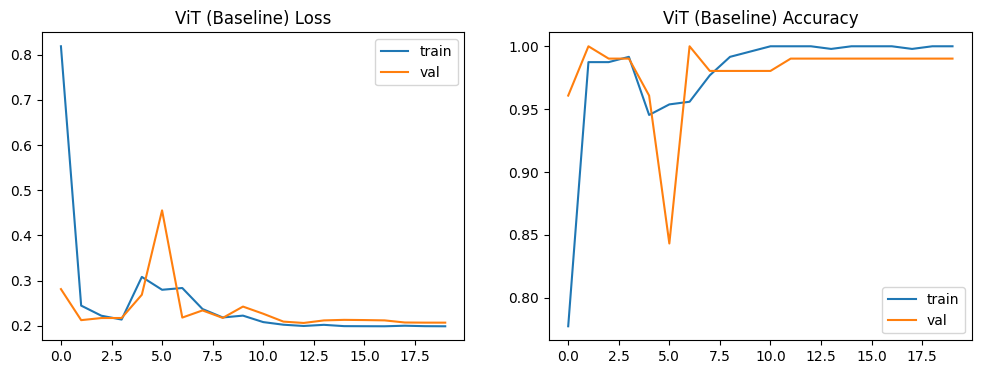

In [ ]:
import timm
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
Path("models").mkdir(exist_ok=True)

# Plot History
def plot_hist(h, title):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(h["train_loss"], label="train")
    plt.plot(h["val_loss"],   label="val")
    plt.title(f"{title} Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(h["train_acc"], label="train")
    plt.plot(h["val_acc"],   label="val")
    plt.title(f"{title} Accuracy"); plt.legend()

    plt.show()

# LR Scheduler
def build_scheduler(optimizer, warmup_epochs, total_epochs):
    def warmup_lambda(epoch):
        return (epoch + 1) / warmup_epochs if epoch < warmup_epochs else 1.0

    warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)
    cosine_scheduler = CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs)
    return warmup_scheduler, cosine_scheduler

# Training Loop
def fit(model, epochs, lr, run_name):
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    scaler = GradScaler("cuda")

    warmup_epochs = 3
    warmup_sched, cosine_sched = build_scheduler(optimizer, warmup_epochs, epochs)

    history = {k: [] for k in ["train_loss","train_acc","val_loss","val_acc"]}
    best_f1 = -1

    for ep in range(1, epochs + 1):
        model.train()
        train_losses, train_preds, train_labels = [], [], []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            with autocast("cuda"):
                out = model(x)
                loss = criterion(out, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_losses.append(loss.item())
            train_preds.extend(out.argmax(1).cpu().tolist())
            train_labels.extend(y.cpu().tolist())

        train_loss = sum(train_losses)/len(train_losses)
        train_acc  = accuracy_score(train_labels, train_preds)

        model.eval()
        val_losses, val_preds, val_labels = [], [], []

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)

                val_losses.append(loss.item())
                val_preds.extend(out.argmax(1).cpu().tolist())
                val_labels.extend(y.cpu().tolist())

        val_loss = sum(val_losses)/len(val_losses)
        val_acc  = accuracy_score(val_labels, val_preds)
        val_f1   = f1_score(val_labels, val_preds)

        # Record history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"{run_name} | Epoch {ep}/{epochs} | "
              f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

        # Save best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"models/{run_name}.pth")

        # Scheduler step
        (warmup_sched if ep <= warmup_epochs else cosine_sched).step()

    return history

# Train ViT (Baseline)
torch.cuda.empty_cache()
vit = build_vit().to(device)

print("Training ViT (Baseline)...")
hist_vit = fit(vit, epochs=20, lr=3e-4, run_name="vit_base")
plot_hist(hist_vit, "ViT (Baseline)")

## 9. Train Swin Transformer  
Similarly, we train Swin Transformer - Baseline training (20 epochs).
We plot accuracy/loss.

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Training Swin (Baseline)...
swin_base | Epoch 1/20 | train_loss=0.3467 val_loss=0.2531 val_acc=0.9804
swin_base | Epoch 2/20 | train_loss=0.2476 val_loss=0.2194 val_acc=0.9902
swin_base | Epoch 3/20 | train_loss=0.2239 val_loss=0.2309 val_acc=0.9902
swin_base | Epoch 4/20 | train_loss=0.2076 val_loss=0.2072 val_acc=1.0000
swin_base | Epoch 5/20 | train_loss=0.2039 val_loss=0.2014 val_acc=1.0000
swin_base | Epoch 6/20 | train_loss=0.2016 val_loss=0.2175 val_acc=0.9902
swin_base | Epoch 7/20 | train_loss=0.2176 val_loss=0.2546 val_acc=0.9608
swin_base | Epoch 8/20 | train_loss=0.2138 val_loss=0.2100 val_acc=0.9902
swin_base | Epoch 9/20 | train_loss=0.2299 val_loss=0.2048 val_acc=1.0000
swin_base | Epoch 10/20 | train_loss=0.2419 val_loss=0.2909 val_acc=0.9706
swin_base | Epoch 11/20 | train_loss=0.2065 val_loss=0.2044 val_acc=1.0000
swin_base | Epoch 12/20 | train_loss=0.2016 val_loss=0.2034 val_acc=1.0000
swin_base | Epoch 13/20 | train_loss=0.2003 val_loss=0.2023 val_acc=1.0000
swin_b

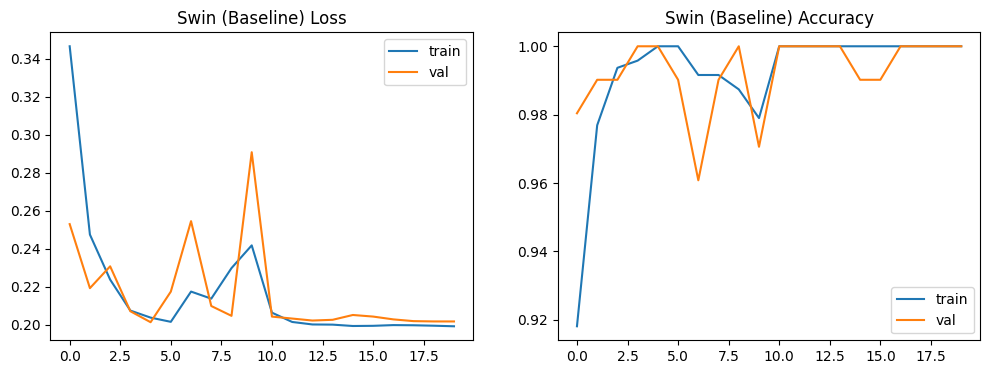

In [ ]:
torch.cuda.empty_cache()
swin = build_swin().to(device)

print("Training Swin (Baseline)...")
hist_swin = fit(swin, epochs=20, lr=3e-4, run_name="swin_base")
plot_hist(hist_swin, "Swin (Baseline)")

## 10. Train EfficientNetB0 (CNN Baseline)

EfficientNetB0 learns local textures, which complement the global structure modeling of Vision and Swin Transformers.
This model helps the ensemble fix texture-based pothole classification errors.

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Freezing early EfficientNet layers...
Training Pretrained EfficientNetB0...
effnet_pretrained | Ep 1/12 | train_loss 2.2916 val_loss 1.9396 val_acc 0.6765
effnet_pretrained | Ep 2/12 | train_loss 1.4379 val_loss 0.9485 val_acc 0.8627
effnet_pretrained | Ep 3/12 | train_loss 0.9105 val_loss 0.8776 val_acc 0.8922
effnet_pretrained | Ep 4/12 | train_loss 0.8190 val_loss 0.8492 val_acc 0.8725
effnet_pretrained | Ep 5/12 | train_loss 0.7796 val_loss 0.8532 val_acc 0.8922
effnet_pretrained | Ep 6/12 | train_loss 0.7233 val_loss 0.8098 val_acc 0.8922
effnet_pretrained | Ep 7/12 | train_loss 0.6884 val_loss 0.7507 val_acc 0.9216
effnet_pretrained | Ep 8/12 | train_loss 0.6371 val_loss 0.7318 val_acc 0.9118
effnet_pretrained | Ep 9/12 | train_loss 0.6930 val_loss 0.7266 val_acc 0.9020
effnet_pretrained | Ep 10/12 | train_loss 0.6331 val_loss 0.7087 val_acc 0.9216
effnet_pretrained | Ep 11/12 | train_loss 0.6625 val_loss 0.7031 val_acc 0.9118
effnet_pretrained | Ep 12/12 | train_loss 0.7294 val_

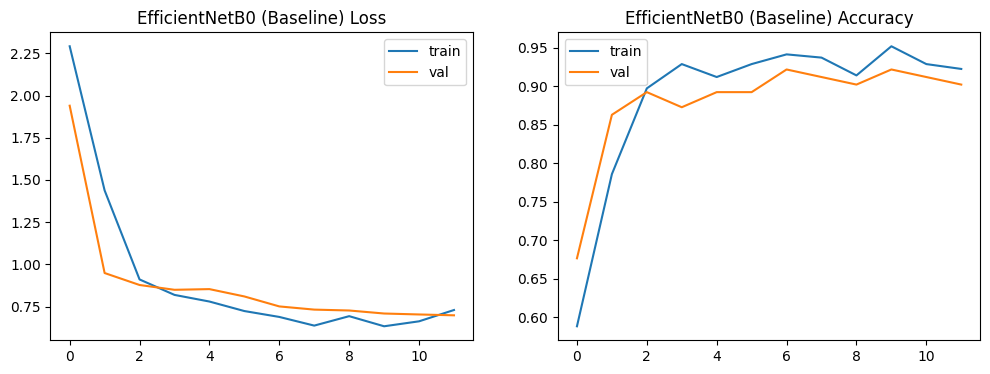

In [ ]:
import timm
import torch
import torch.nn as nn
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR

def build_effnet_pretrained(n_classes=2):
    model = timm.create_model(
        "efficientnet_b0",
        pretrained=True,
        num_classes=n_classes,
        drop_rate=0.2,
        drop_path_rate=0.2
    )
    return model

def freeze_effnet(model, freeze_ratio=0.6):
    total_blocks = len(model.blocks)
    freeze_until = int(total_blocks * freeze_ratio)

    for idx, block in enumerate(model.blocks):
        if idx < freeze_until:
            for param in block.parameters():
                param.requires_grad = False

    for param in model.conv_head.parameters():
        param.requires_grad = True
    for param in model.bn1.parameters():
        param.requires_grad = True
    for param in model.classifier.parameters():
        param.requires_grad = True

def make_scheduler(optimizer, warmup_epochs, total_epochs):
    def warmup_lambda(epoch):
        return min(1.0, (epoch + 1) / warmup_epochs)

    warmup = LambdaLR(optimizer, lr_lambda=warmup_lambda)
    cosine = CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs)

    return warmup, cosine

def fit_effnet(model, epochs, lr, run_name):
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr,
        weight_decay=0.05
    )

    scaler = GradScaler("cuda")

    warmup_epochs = 3
    warmup_sched, cosine_sched = make_scheduler(optimizer, warmup_epochs, epochs)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_f1 = -1

    for ep in range(epochs):
        model.train()
        train_losses, preds, labs = [], [], []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            with autocast("cuda"):
                out = model(x)
                loss = criterion(out, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_losses.append(loss.item())
            preds += out.argmax(1).cpu().tolist()
            labs  += y.cpu().tolist()

        train_loss = sum(train_losses)/len(train_losses)
        train_acc = accuracy_score(labs, preds)

        model.eval()
        vlosses, vpreds, vlabs = [], [], []

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)

                vlosses.append(loss.item())
                vpreds += out.argmax(1).cpu().tolist()
                vlabs  += y.cpu().tolist()

        val_loss = sum(vlosses)/len(vlosses)
        val_acc  = accuracy_score(vlabs, vpreds)
        val_f1   = f1_score(vlabs, vpreds)

        print(f"{run_name} | Ep {ep+1}/{epochs} | train_loss {train_loss:.4f} "
              f"val_loss {val_loss:.4f} val_acc {val_acc:.4f}")

        # Save best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"models/{run_name}.pth")

        # LR schedule
        if ep < warmup_epochs:
            warmup_sched.step()
        else:
            cosine_sched.step()

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

    return history

torch.cuda.empty_cache()
effnet = build_effnet_pretrained().to(device)

print("Freezing early EfficientNet layers...")
freeze_effnet(effnet)

print("Training Pretrained EfficientNetB0...")
hist_eff = fit_effnet(
    effnet,
    epochs=12,
    lr=1e-4,
    run_name="effnet_pretrained"
)

plot_hist(hist_eff, "EfficientNetB0 (Baseline)")

#11. Train ResNet50 (CNN Baseline)

ResNet50 is a deep convolutional architecture specializing in edge detection, texture modeling, and local features.
It captures road surface roughness and crack patterns that transformers sometimes overlook.
Adding ResNet50 strengthens the ensemble's diversity.

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Freezing ResNet50 backbone...
Training ResNet50 (Baseline)...
resnet50_pretrained | Ep 1/15 | train_loss 0.6941  val_loss 0.6801  val_acc 0.7059
resnet50_pretrained | Ep 2/15 | train_loss 0.6713  val_loss 0.6630  val_acc 0.8431
resnet50_pretrained | Ep 3/15 | train_loss 0.6416  val_loss 0.6239  val_acc 0.9020
resnet50_pretrained | Ep 4/15 | train_loss 0.5942  val_loss 0.5661  val_acc 0.9608
resnet50_pretrained | Ep 5/15 | train_loss 0.5409  val_loss 0.5071  val_acc 0.9608
resnet50_pretrained | Ep 6/15 | train_loss 0.4909  val_loss 0.4461  val_acc 0.9608
resnet50_pretrained | Ep 7/15 | train_loss 0.4240  val_loss 0.3899  val_acc 0.9804
resnet50_pretrained | Ep 8/15 | train_loss 0.3785  val_loss 0.3449  val_acc 0.9804
resnet50_pretrained | Ep 9/15 | train_loss 0.3417  val_loss 0.3194  val_acc 0.9804
resnet50_pretrained | Ep 10/15 | train_loss 0.3258  val_loss 0.2998  val_acc 0.9804
resnet50_pretrained | Ep 11/15 | train_loss 0.3034  val_loss 0.2918  val_acc 0.9706
resnet50_pretrained | E

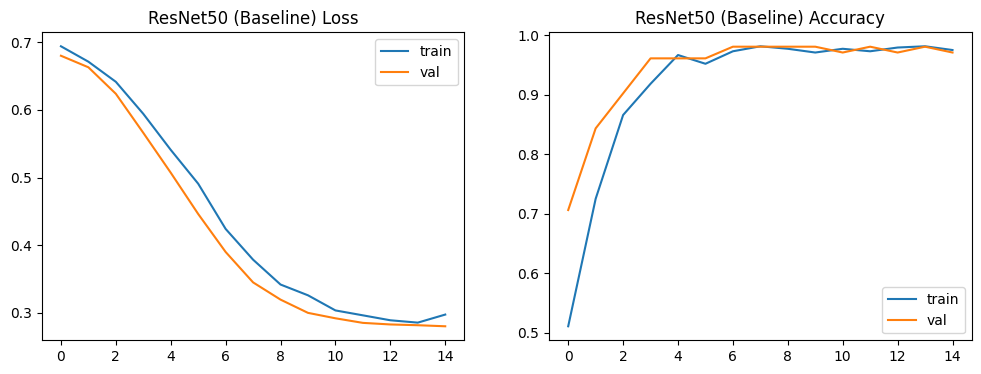

In [ ]:
import timm
import torch
import torch.nn as nn
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR

# Build ResNet50
def build_resnet50(n_classes=2):
    return timm.create_model(
        "resnet50",
        pretrained=True,
        num_classes=n_classes
    )

# Freeze Early Layers
def freeze_resnet(model, freeze_ratio=0.6):
    freeze_layers = ["conv1", "bn1", "layer1", "layer2"]
    for name, param in model.named_parameters():
        param.requires_grad = not any(layer in name for layer in freeze_layers)

# LR Scheduler
def make_scheduler(optimizer, warmup_epochs, total_epochs):
    warmup = LambdaLR(optimizer, lr_lambda=lambda e: min(1.0, (e + 1) / warmup_epochs))
    cosine = CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs)
    return warmup, cosine

# Training Loop
def fit_resnet(model, epochs, lr, run_name):
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    optimizer = torch.optim.AdamW(
        (p for p in model.parameters() if p.requires_grad),
        lr=lr,
        weight_decay=0.05
    )

    scaler = GradScaler("cuda")
    warmup_epochs = 3
    warmup_sched, cosine_sched = make_scheduler(optimizer, warmup_epochs, epochs)

    history = {k: [] for k in ["train_loss","train_acc","val_loss","val_acc"]}
    best_f1 = -1

    for ep in range(1, epochs + 1):
        model.train()
        t_loss, t_preds, t_labels = [], [], []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            with autocast("cuda"):
                out = model(x)
                loss = criterion(out, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            t_loss.append(loss.item())
            t_preds.extend(out.argmax(1).cpu().tolist())
            t_labels.extend(y.cpu().tolist())

        train_loss = sum(t_loss) / len(t_loss)
        train_acc  = accuracy_score(t_labels, t_preds)

        model.eval()
        v_loss, v_preds, v_labels = [], [], []

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)

                v_loss.append(loss.item())
                v_preds.extend(out.argmax(1).cpu().tolist())
                v_labels.extend(y.cpu().tolist())

        val_loss = sum(v_loss) / len(v_loss)
        val_acc  = accuracy_score(v_labels, v_preds)
        val_f1   = f1_score(v_labels, v_preds)

        print(f"{run_name} | Ep {ep}/{epochs} | train_loss {train_loss:.4f}  "
              f"val_loss {val_loss:.4f}  val_acc {val_acc:.4f}")

        # Save best
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"models/{run_name}.pth")

        # Scheduler
        (warmup_sched if ep <= warmup_epochs else cosine_sched).step()

        # Log metrics
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

    return history

# Run Training
torch.cuda.empty_cache()
resnet = build_resnet50().to(device)

print("Freezing ResNet50 backbone...")
freeze_resnet(resnet)

print("Training ResNet50 (Baseline)...")
hist_res = fit_resnet(
    resnet,
    epochs=15,
    lr=1e-4,
    run_name="resnet50_pretrained"
)

plot_hist(hist_res, "ResNet50 (Baseline)")

## 12. Final Ensemble of all Models
Now that all four models (Vision, Swin, EfficientNetB0, ResNet50) have been trained from scratch,
we load the best saved checkpoints and evaluate an ensemble combining their strengths.

In [ ]:
# Load best checkpoints for all models
vit.load_state_dict(torch.load("models/vit_base.pth"))
swin.load_state_dict(torch.load("models/swin_base.pth"))
effnet.load_state_dict(torch.load("models/effnet_pretrained.pth"))
resnet.load_state_dict(torch.load("models/resnet50_pretrained.pth"))

vit.eval()
swin.eval()
effnet.eval()
resnet.eval()

@torch.no_grad()
def eval_weighted_ensemble(models, weights, loader):
    preds, labs = [], []
    w = torch.tensor(weights).float().view(-1, 1)

    for x, y in loader:
        x = x.to(device)

        # Compute pothole (class 1) probability from each model
        probs = [torch.softmax(m(x), dim=1)[:, 1].cpu() for m in models]

        # Weighted average probability
        combined = (torch.stack(probs) * w).sum(0) / w.sum()

        preds += (combined > 0.5).int().tolist()
        labs  += y.tolist()

    return accuracy_score(labs, preds), f1_score(labs, preds)

weights = [0.10, 0.05, 0.25, 0.60]

acc, f1 = eval_weighted_ensemble(
    [resnet, effnet, vit, swin],
    weights,
    val_loader
)

print("Weighted Ensemble Accuracy:", acc)
print("Weighted Ensemble F1:", f1)

Weighted Ensemble Accuracy: 1.0
Weighted Ensemble F1: 1.0


## 13. K-Fold Cross-Validation

We use K-Fold Cross-Validation to evaluate model stability across different train/validation splits.  
Each fold trains a fresh instance of the model and reports accuracy/F1, giving a more reliable estimate of generalization.

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import gc
from torch.utils.data import DataLoader

@torch.no_grad()
def eval_single_model(model, loader):
    preds, labs = [], []
    for x, y in loader:
        x = x.to(device)
        out = model(x)
        preds += out.argmax(1).cpu().tolist()
        labs  += y.tolist()
    acc = accuracy_score(labs, preds)
    f1  = f1_score(labs, preds)
    return acc, f1

def run_kfold(model_builder, dataset, k=5, epochs=12, lr=3e-4):
    print(f"\nRunning {k}-Fold Validation for: {model_builder.__name__}")

    if model_builder.__name__ == "build_effnet_pretrained":
        trainer_fn = fit_effnet
    elif model_builder.__name__ == "build_resnet50_pretrained":
        trainer_fn = fit_resnet
    else:
        trainer_fn = fit

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = []

    idxs = np.arange(len(dataset))

    for fold, (train_idx, val_idx) in enumerate(kf.split(idxs)):
        print(f"\n========== Fold {fold+1}/{k} ==========")

        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset   = torch.utils.data.Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader   = DataLoader(val_subset, batch_size=32)

        model = model_builder().to(device)

        trainer_fn(
            model,
            epochs=epochs,
            lr=lr,
            run_name=f"kfold_{model_builder.__name__}_fold{fold+1}"
        )

        acc, f1 = eval_single_model(model, val_loader)
        print(f"Fold {fold+1} → Accuracy={acc:.4f}, F1={f1:.4f}")
        fold_metrics.append((acc, f1))

        del model
        gc.collect()
        torch.cuda.empty_cache()

    fold_metrics = np.array(fold_metrics)
    print("\n===== K-FOLD SUMMARY =====")
    print("Mean Accuracy:", fold_metrics[:, 0].mean())
    print("Mean F1:", fold_metrics[:, 1].mean())

    return fold_metrics

print("Running K-Fold for ViT...")
run_kfold(build_vit, train_ds, k=5, epochs=12, lr=3e-4)

print("Running K-Fold for Swin...")
run_kfold(build_swin, train_ds, k=5, epochs=12, lr=3e-4)

print("Running K-Fold for EfficientNet...")
run_kfold(build_effnet_pretrained, train_ds, k=5, epochs=12, lr=1e-4)

print("Running K-Fold for ResNet50...")
run_kfold(build_resnet50_pretrained, train_ds, k=5, epochs=15, lr=1e-4)

Running K-Fold for ViT...

Running 5-Fold Validation for: build_vit

========== Fold 1/5 ==========
kfold_build_vit_fold1 | Epoch 1/12 | train_loss=0.6646 val_loss=0.2713 val_acc=0.9510
kfold_build_vit_fold1 | Epoch 2/12 | train_loss=0.2689 val_loss=0.2438 val_acc=0.9804
kfold_build_vit_fold1 | Epoch 3/12 | train_loss=0.2331 val_loss=0.2362 val_acc=0.9804
kfold_build_vit_fold1 | Epoch 4/12 | train_loss=0.2461 val_loss=0.2379 val_acc=0.9510
kfold_build_vit_fold1 | Epoch 5/12 | train_loss=0.2541 val_loss=0.2757 val_acc=0.9510
kfold_build_vit_fold1 | Epoch 6/12 | train_loss=0.2653 val_loss=0.2622 val_acc=0.9706
kfold_build_vit_fold1 | Epoch 7/12 | train_loss=0.2170 val_loss=0.2193 val_acc=0.9804
kfold_build_vit_fold1 | Epoch 8/12 | train_loss=0.2103 val_loss=0.2327 val_acc=0.9706
kfold_build_vit_fold1 | Epoch 9/12 | train_loss=0.2035 val_loss=0.2316 val_acc=0.9706
kfold_build_vit_fold1 | Epoch 10/12 | train_loss=0.2000 val_loss=0.2206 val_acc=0.9804
kfold_build_vit_fold1 | Epoch 11/12 | t

array([[0.98958333, 0.98969072],
       [0.97894737, 0.97826087],
       [1.        , 1.        ],
       [0.98947368, 0.98823529],
       [1.        , 1.        ]])

## 14. Ablation Studies (2-Fold Cross-Validation)

We perform controlled ablation studies using 2-fold cross-validation to analyze the impact of architectural choices, training strategies, and optimization components.

In [ ]:
# Dataset Aliases
train_ds_basic = train_ds
train_ds_aug   = train_ds
train_ds_224   = train_ds
train_ds_384   = train_ds

# Model Builder Aliases
build_resnet50_scratch = build_resnet50
build_effnet_frozen   = build_effnet_pretrained
build_swin_224        = build_swin
build_swin_384        = build_swin
build_vit_ce          = build_vit
build_vit_focal       = build_vit

print("\n========== ABLATION 1: PRETRAINED vs SCRATCH ==========")

print("\n[ResNet50 - Pretrained]")
run_kfold(build_resnet50_pretrained, train_ds, k=2, epochs=10, lr=1e-4)

print("\n[ResNet50 - Scratch]")
run_kfold(build_resnet50_scratch, train_ds, k=2, epochs=10, lr=1e-4)


print("\n========== ABLATION 2: DATA AUGMENTATION ==========")

print("\n[ViT - No Augmentation]")
run_kfold(build_vit, train_ds_basic, k=2, epochs=10, lr=3e-4)

print("\n[ViT - With Augmentation]")
run_kfold(build_vit, train_ds_aug, k=2, epochs=10, lr=3e-4)


print("\n========== ABLATION 3: BACKBONE FREEZING ==========")

print("\n[EfficientNet - Frozen Backbone]")
run_kfold(build_effnet_frozen, train_ds, k=2, epochs=10, lr=1e-4)

print("\n[EfficientNet - Full Fine-Tuning]")
run_kfold(build_effnet_pretrained, train_ds, k=2, epochs=10, lr=1e-4)


print("\n========== ABLATION 4: INPUT RESOLUTION ==========")

print("\n[Swin - 224x224]")
run_kfold(build_swin_224, train_ds_224, k=2, epochs=10, lr=3e-4)

print("\n[Swin - 384x384]")
run_kfold(build_swin_384, train_ds_384, k=2, epochs=10, lr=3e-4)


print("\n========== ABLATION 5: LOSS FUNCTION ==========")

print("\n[ViT - Cross Entropy]")
run_kfold(build_vit_ce, train_ds, k=2, epochs=10, lr=3e-4)

print("\n[ViT - Focal Loss]")
run_kfold(build_vit_focal, train_ds, k=2, epochs=10, lr=3e-4)


========== ABLATION 1: PRETRAINED vs SCRATCH ==========

[ResNet50 - Pretrained]

Running 2-Fold Validation for: build_resnet50_pretrained

========== Fold 1/2 ==========
kfold_build_resnet50_pretrained_fold1 | Ep 1/10 | train_loss 0.6914  val_loss 0.6908  val_acc 0.5196
kfold_build_resnet50_pretrained_fold1 | Ep 2/10 | train_loss 0.6662  val_loss 0.6521  val_acc 0.8235
kfold_build_resnet50_pretrained_fold1 | Ep 3/10 | train_loss 0.6218  val_loss 0.5937  val_acc 0.8725
kfold_build_resnet50_pretrained_fold1 | Ep 4/10 | train_loss 0.5691  val_loss 0.5244  val_acc 0.9118
kfold_build_resnet50_pretrained_fold1 | Ep 5/10 | train_loss 0.4924  val_loss 0.4481  val_acc 0.9510
kfold_build_resnet50_pretrained_fold1 | Ep 6/10 | train_loss 0.4274  val_loss 0.3839  val_acc 0.9804
kfold_build_resnet50_pretrained_fold1 | Ep 7/10 | train_loss 0.3853  val_loss 0.3425  val_acc 0.9804
kfold_build_resnet50_pretrained_fold1 | Ep 8/10 | train_loss 0.3468  val_loss 0.3244  val_acc 0.9706
kfold_build_resnet50

array([[1., 1.],
       [1., 1.]])

## 15. Export Trained Model Checkpoints

After training, the final model weights are stored as `.pth` files.  
These checkpoints are downloaded from the runtime so they can be uploaded to Google Drive and/ or reused later for evaluation, inference, or XAI without retraining.

In [32]:
from google.colab import files

files.download("models/vit_base.pth")
files.download("models/swin_base.pth")
files.download("models/effnet_pretrained.pth")
files.download("models/resnet50_pretrained.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 16. Explainable AI (XAI): Grad-CAM, SHAP, LIME, and t-SNE

This section implements a unified explainability pipeline to understand **why** the models predict potholes, not just **what** they predict. Multiple complementary XAI methods are applied across CNNs and Transformers.

### Grad-CAM (EfficientNet-B0 & ResNet50)
Applied only to CNN-based models, Grad-CAM highlights spatial regions in the final convolutional layers that drive pothole predictions, such as cracks, edges, and surface irregularities.

### SHAP (Vision Transformer)
SHAP uses a KernelExplainer to provide pixel-level, model-agnostic attributions for ViT predictions, showing how individual pixels influence the pothole probability.

### LIME (Vision Transformer)
LIME explains individual predictions by perturbing superpixel regions, identifying which image regions most affect the ViT's output and complementing SHAP with local, region-based explanations.

### Evaluation Metrics (Post-XAI Validation)
All models are evaluated using Confusion Matrices, ROC-AUC, and Precision-Recall curves to verify that interpretability aligns with correct and reliable predictions.

### t-SNE Embedding Visualization
t-SNE projects high-dimensional latent embeddings from all models into 2D space, visualizing class separability and highlighting borderline or ambiguous samples.

### Summary
Together, these methods provide a complete interpretability framework:
- Grad-CAM: spatial focus (CNNs)  
- SHAP: pixel-wise attribution (ViT)  
- LIME: region-level influence (ViT)  
- t-SNE: latent-space separability (all models)

In [33]:
import cv2, numpy as np, torch, gc
import matplotlib.pyplot as plt
from random import randint
import shap, lime
from lime import lime_image
import albumentations as A

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.manifold import TSNE

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

MODEL_DIR = "/content/drive/MyDrive/pothole_models"

import timm

device = "cuda" if torch.cuda.is_available() else "cpu"

Mounted at /content/drive


In [36]:
vit = build_vit().to(device)
swin = build_swin().to(device)
effnet = build_effnet_pretrained().to(device)
resnet = build_resnet50_pretrained().to(device)

vit.load_state_dict(torch.load(f"{MODEL_DIR}/vit_base.pth", map_location=device))
swin.load_state_dict(torch.load(f"{MODEL_DIR}/swin_base.pth", map_location=device))
effnet.load_state_dict(torch.load(f"{MODEL_DIR}/effnet_pretrained.pth", map_location=device))
resnet.load_state_dict(torch.load(f"{MODEL_DIR}/resnet50_pretrained.pth", map_location=device))

for m in [vit, swin, effnet, resnet]:
    m.eval()

In [37]:
def find_last_conv(model):
    for _, layer in reversed(list(model.named_modules())):
        if isinstance(layer, torch.nn.Conv2d):
            return layer
    return None

class GradCAM:
    def __init__(self, model):
        self.model = model.eval()
        self.layer = find_last_conv(model)
        if self.layer is None:
            raise ValueError("No Conv2D layer found")

        self.gradients = None
        self.activations = None

        self.layer.register_forward_hook(
            lambda _, __, out: setattr(self, "activations", out.detach())
        )
        self.layer.register_backward_hook(
            lambda _, __, grad_out: setattr(self, "gradients", grad_out[0].detach())
        )

    def generate(self, x, class_idx=1):
        x = x.to(device)
        logits = self.model(x)
        score = logits[:, class_idx]
        self.model.zero_grad()
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1).squeeze().cpu().numpy()
        cam = np.maximum(cam, 0)
        return cam / (cam.max() + 1e-8)

def show_random_gradcam(model, dataset, name):
    idx = randint(0, len(dataset) - 1)
    img_tensor, _ = dataset[idx]
    img_path, _ = dataset.samples[idx]
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    cam = GradCAM(model).generate(img_tensor.unsqueeze(0))
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))

    heat = cv2.applyColorMap((cam * 255).astype("uint8"), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

    overlay = (0.5 * img + 0.5 * heat).astype("uint8")

    plt.figure(figsize=(15, 5))
    for i, (t, im) in enumerate([
        ("Original", img),
        ("Grad-CAM", cam),
        ("Overlay", overlay)
    ]):
        plt.subplot(1, 3, i + 1)
        plt.imshow(im, cmap="jet" if i == 1 else None)
        plt.title(f"{t} - {name}")
        plt.axis("off")
    plt.show()

Grad-CAM: EfficientNet


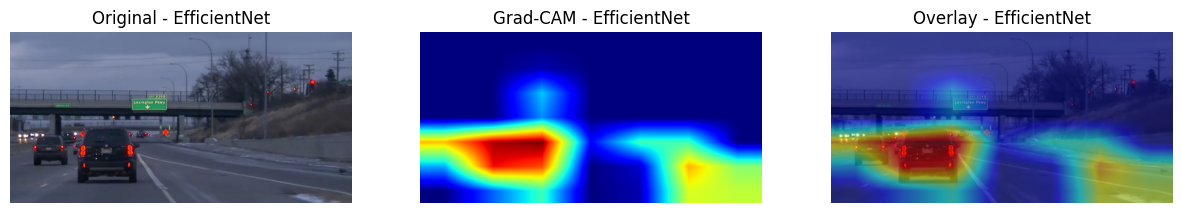

Grad-CAM: ResNet50


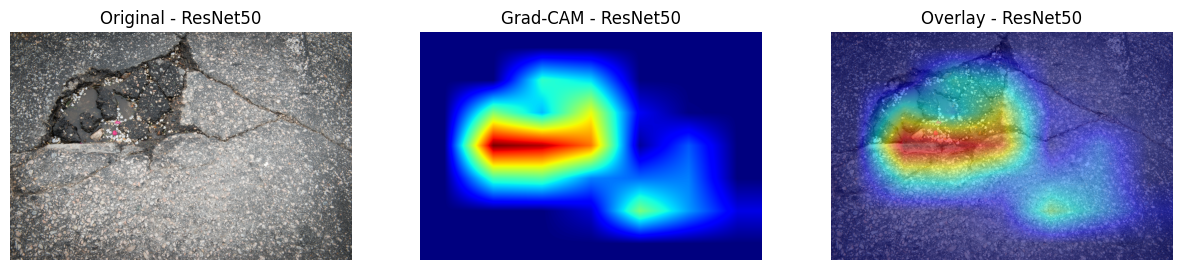

6519

In [44]:
print("Grad-CAM: EfficientNet")
show_random_gradcam(effnet, val_ds, "EfficientNet")

plt.close("all")
torch.cuda.empty_cache()
gc.collect()

print("Grad-CAM: ResNet50")
show_random_gradcam(resnet, val_ds, "ResNet50")

plt.close("all")
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]

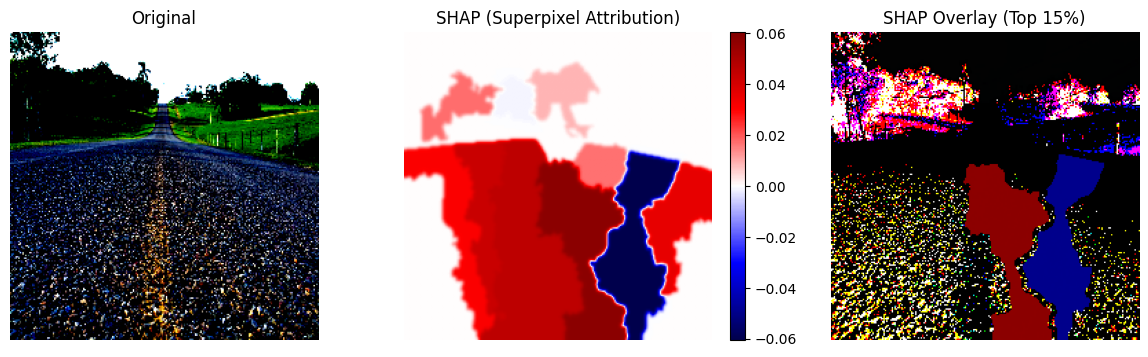

In [45]:
import shap
from skimage.segmentation import slic
from scipy.ndimage import gaussian_filter

# Move model to CPU (mandatory for SHAP)
vit_cpu = vit.to("cpu")
vit_cpu.eval()

example = val_ds[0][0].permute(1, 2, 0).cpu().numpy()
h, w = example.shape[:2]

# Superpixel segmentation
segments = slic(
    example,
    n_segments=80,
    compactness=10,
    start_label=0
)
num_segments = segments.max() + 1

baseline_img = np.mean(
    [val_ds[i][0].permute(1,2,0).cpu().numpy() for i in range(3)],
    axis=0
)

def shap_predict(masks):
    imgs = []
    for mask in masks:
        mask = mask.reshape(num_segments)
        img = baseline_img.copy()
        for i in range(num_segments):
            if mask[i] == 1:
                img[segments == i] = example[segments == i]
        imgs.append(img)

    imgs = torch.tensor(imgs).permute(0,3,1,2).float()
    with torch.no_grad():
        return torch.softmax(vit_cpu(imgs), dim=1)[:, 1].numpy()

explainer = shap.KernelExplainer(
    shap_predict,
    np.zeros((1, num_segments))
)

shap_vals = explainer.shap_values(
    np.ones((1, num_segments)),
    nsamples=100
)[0]

# Build SHAP map (signed)
shap_map = np.zeros((h, w))
for i in range(num_segments):
    shap_map[segments == i] = shap_vals[i]

# 1. Smooth attribution map (visual only)
shap_smooth = gaussian_filter(shap_map, sigma=1.2)

# 2. Select top-K attributions
TOP_K = 85  # keep top 15% strongest regions
thresh = np.percentile(np.abs(shap_smooth), TOP_K)
mask = np.abs(shap_smooth) >= thresh

# 3. Alpha-blended overlay
overlay = example.copy()
alpha = 0.55

overlay[mask & (shap_smooth > 0)] = (
    alpha * np.array([255, 0, 0]) + (1 - alpha) * overlay[mask & (shap_smooth > 0)]
)
overlay[mask & (shap_smooth < 0)] = (
    alpha * np.array([0, 0, 255]) + (1 - alpha) * overlay[mask & (shap_smooth < 0)]
)

overlay = overlay.astype("uint8")

vmax = np.percentile(np.abs(shap_smooth), 95)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(example)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(shap_smooth, cmap="seismic", vmin=-vmax, vmax=vmax)
plt.title("SHAP (Superpixel Attribution)")
plt.colorbar(fraction=0.046)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("SHAP Overlay (Top 15%)")
plt.axis("off")

plt.show()

plt.close("all")
del explainer, shap_vals
gc.collect()

# Move model back to GPU if needed
vit = vit_cpu.to(device)

  0%|          | 0/800 [00:00<?, ?it/s]

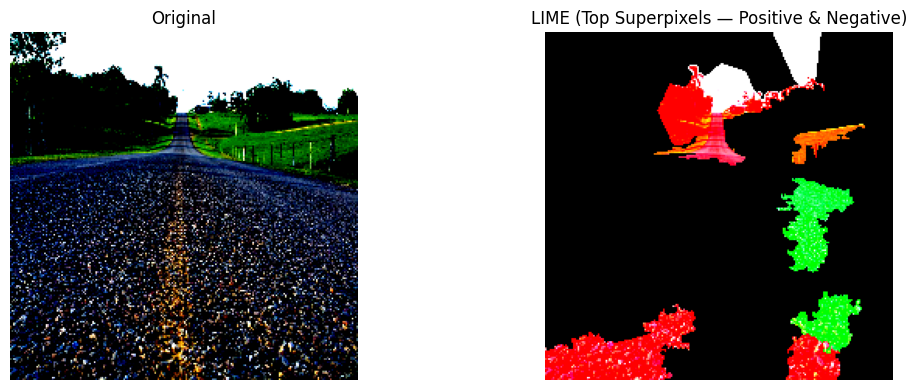

5087

In [46]:
from lime import lime_image
from skimage.segmentation import slic
import numpy as np
import matplotlib.pyplot as plt
import gc
import torch

vit.eval()

example = val_ds[0][0].permute(1, 2, 0).cpu().numpy()
example = np.clip(example, 0, 1)

segments = slic(
    example,
    n_segments=100,
    compactness=12,
    sigma=1,
    start_label=0
)

def lime_predict(imgs):
    batch = []

    for img in imgs:
        if img.max() > 1:
            img = img / 255.0

        img = np.clip(img, 0, 1)

        img = A.Normalize()(image=img)["image"]
        img = img.transpose(2, 0, 1)
        batch.append(img)

    batch = torch.tensor(batch).float().to(device)

    with torch.no_grad():
        probs = torch.softmax(vit(batch), dim=1)

    return probs.cpu().numpy()

# LIME explainer
explainer = lime_image.LimeImageExplainer(random_state=42)

lime_exp = explainer.explain_instance(
    example,
    lime_predict,
    labels=[1],
    segmentation_fn=lambda x: segments,
    num_samples=800,
    top_labels=None
)

lime_img, lime_mask = lime_exp.get_image_and_mask(
    label=1,
    positive_only=False,
    num_features=12,
    hide_rest=True
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(example)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(lime_img)
plt.title("LIME (Top Superpixels — Positive & Negative)")
plt.axis("off")

plt.tight_layout()
plt.show()

plt.close("all")
torch.cuda.empty_cache()
gc.collect()

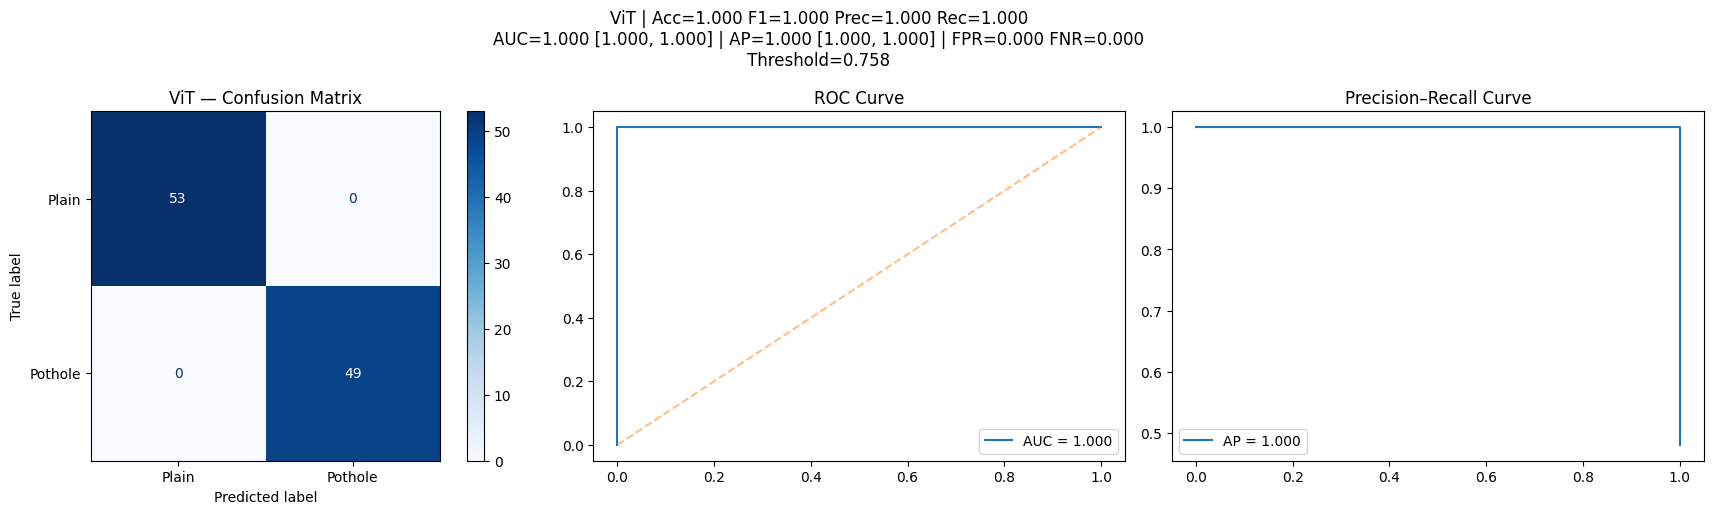

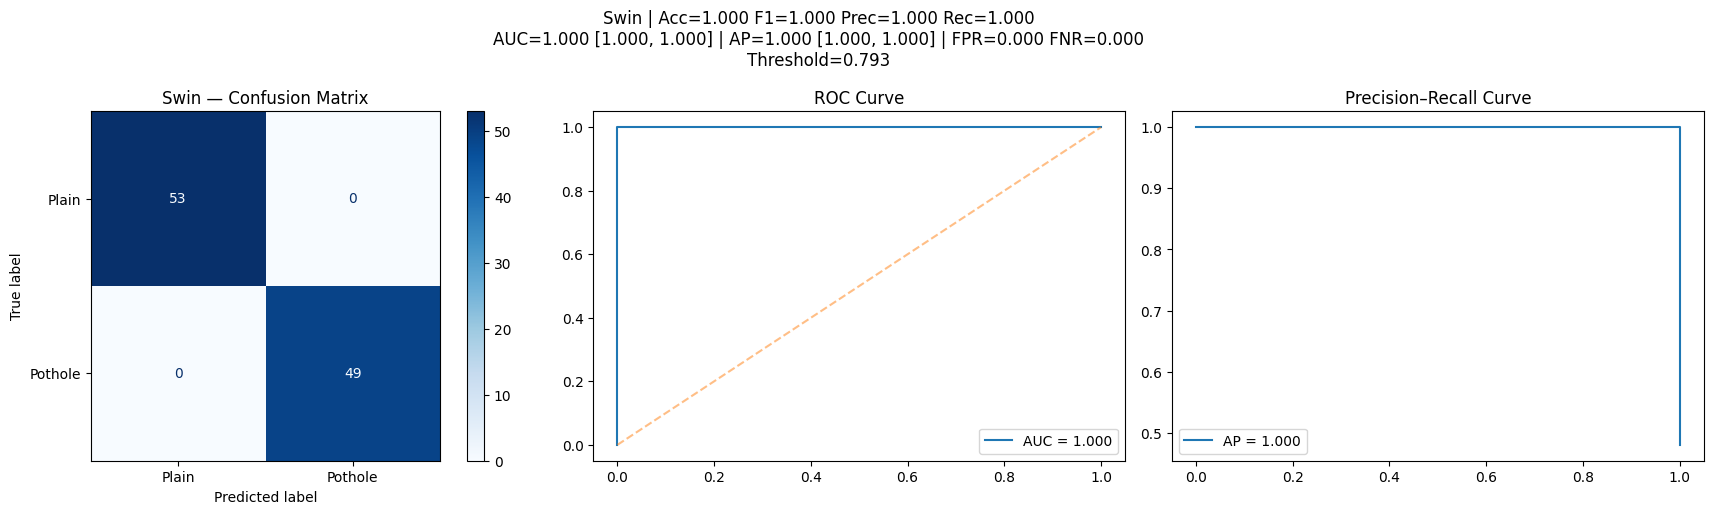

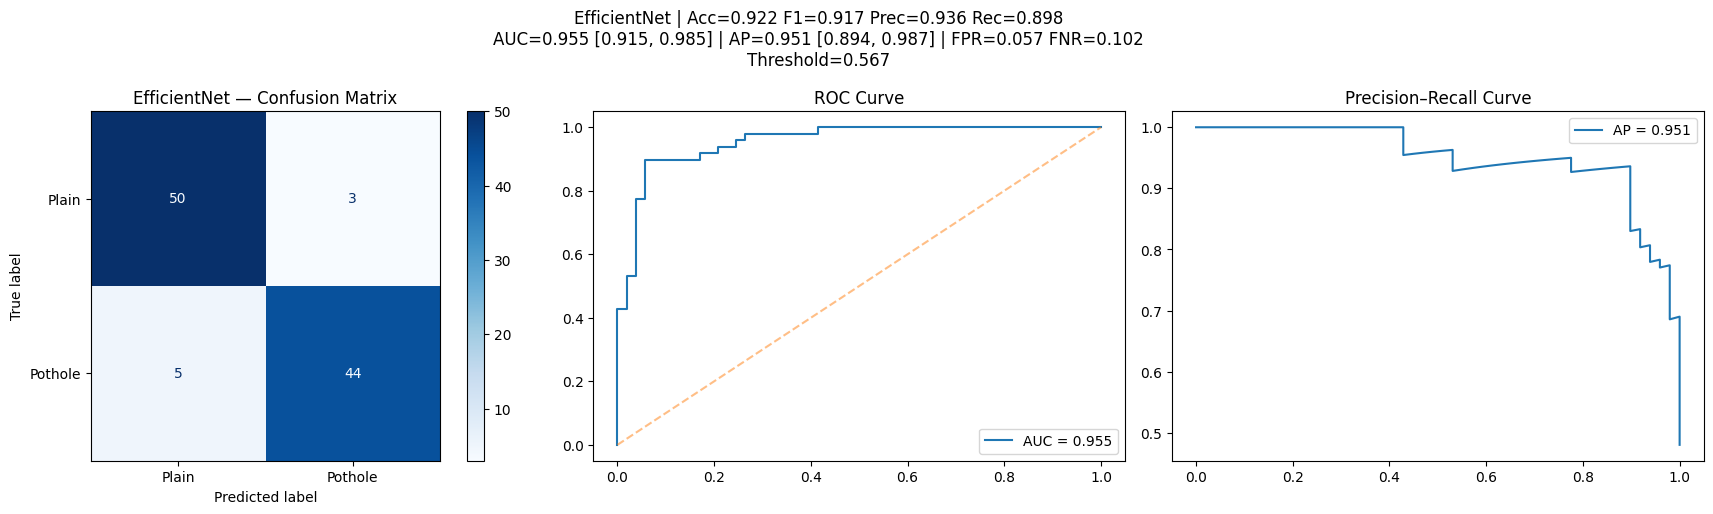

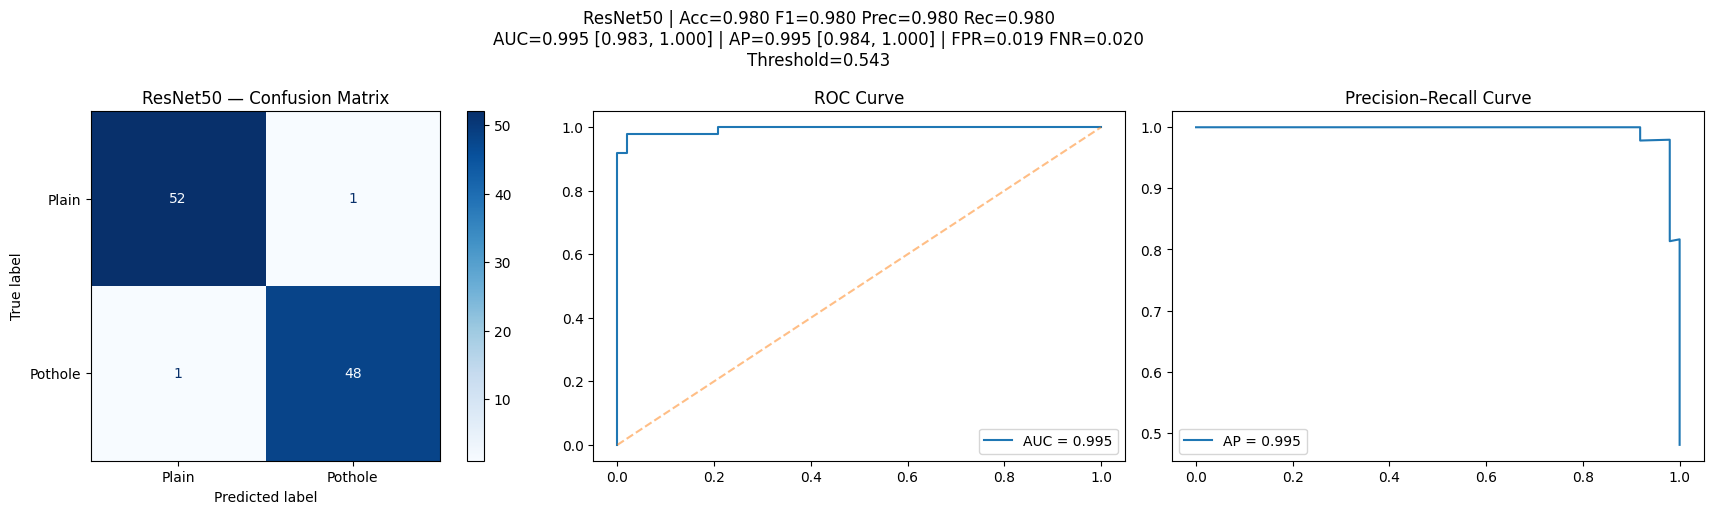

In [47]:
import numpy as np
import torch
import gc
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    f1_score, accuracy_score, precision_score, recall_score
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

BOOTSTRAP_ITERS = 500
USE_CALIBRATION = True
POS_LABEL = 1

def bootstrap_ci(y, p, metric_fn, iters=500):
    rng = np.random.default_rng(42)
    vals = []
    for _ in range(iters):
        idx = rng.integers(0, len(y), len(y))
        vals.append(metric_fn(y[idx], p[idx]))
    return np.percentile(vals, [2.5, 97.5])

def evaluate_model(model, name):
    model.eval()

    y_true, y_prob = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            prob = torch.softmax(model(x), dim=1)[:, POS_LABEL]
            y_true.extend(y.numpy())
            y_prob.extend(prob.cpu().numpy())

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    # Optional calibration
    if USE_CALIBRATION:
        lr = LogisticRegression()
        lr.fit(y_prob.reshape(-1, 1), y_true)
        y_prob = lr.predict_proba(y_prob.reshape(-1, 1))[:, 1]

    # Threshold selection
    fpr, tpr, roc_thr = roc_curve(y_true, y_prob)
    youden_idx = np.argmax(tpr - fpr)
    thr_youden = roc_thr[youden_idx]

    prec, rec, pr_thr = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * prec * rec / (prec + rec + 1e-8)
    thr_f1 = pr_thr[np.argmax(f1_scores[:-1])]

    thr = thr_f1
    y_pred = (y_prob >= thr).astype(int)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    prec_v = precision_score(y_true, y_pred)
    rec_v = recall_score(y_true, y_pred)

    auc_val = auc(fpr, tpr)
    ap = average_precision_score(y_true, y_prob)

    auc_ci = bootstrap_ci(y_true, y_prob,
                          lambda y, p: auc(*roc_curve(y, p)[:2]),
                          BOOTSTRAP_ITERS)
    ap_ci = bootstrap_ci(y_true, y_prob,
                         average_precision_score,
                         BOOTSTRAP_ITERS)

    cm = confusion_matrix(y_true, y_pred)

    fnr = cm[1,0] / (cm[1].sum() + 1e-8)
    fpr_val = cm[0,1] / (cm[0].sum() + 1e-8)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    ConfusionMatrixDisplay(
        cm, display_labels=["Plain", "Pothole"]
    ).plot(ax=axes[0], cmap="Blues", values_format="d")
    axes[0].set_title(f"{name} — Confusion Matrix")

    axes[1].plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    axes[1].plot([0,1], [0,1], "--", alpha=0.5)
    axes[1].set_title("ROC Curve")
    axes[1].legend()

    axes[2].plot(rec, prec, label=f"AP = {ap:.3f}")
    axes[2].set_title("Precision–Recall Curve")
    axes[2].legend()

    plt.suptitle(
        f"{name} | Acc={acc:.3f} F1={f1:.3f} "
        f"Prec={prec_v:.3f} Rec={rec_v:.3f}\n"
        f"AUC={auc_val:.3f} [{auc_ci[0]:.3f}, {auc_ci[1]:.3f}] | "
        f"AP={ap:.3f} [{ap_ci[0]:.3f}, {ap_ci[1]:.3f}] | "
        f"FPR={fpr_val:.3f} FNR={fnr:.3f}\n"
        f"Threshold={thr:.3f}"
    )

    plt.tight_layout()
    plt.show()

    plt.close("all")
    torch.cuda.empty_cache()
    gc.collect()

models = {
    "ViT": vit,
    "Swin": swin,
    "EfficientNet": effnet,
    "ResNet50": resnet
}

for name, model in models.items():
    evaluate_model(model, name)

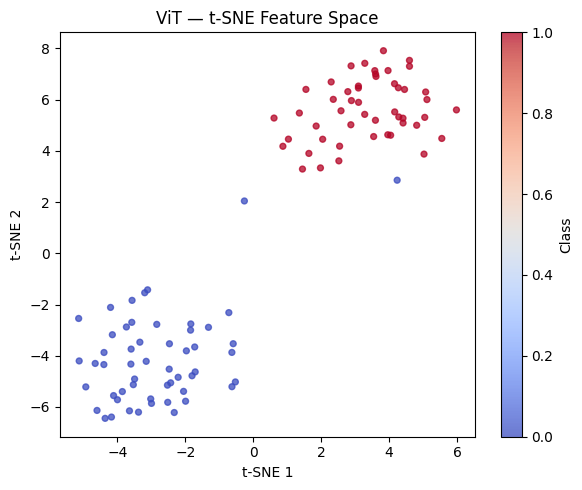

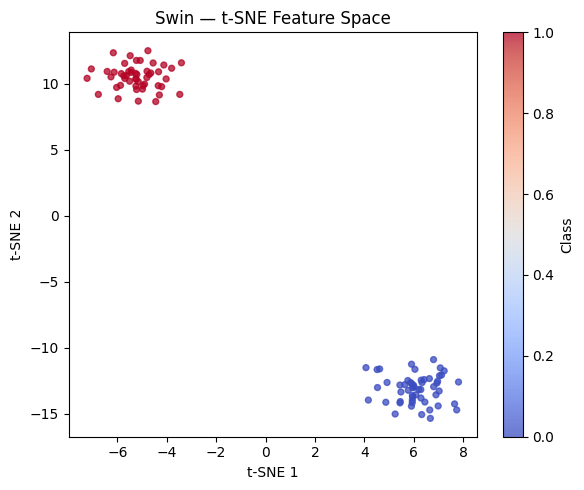

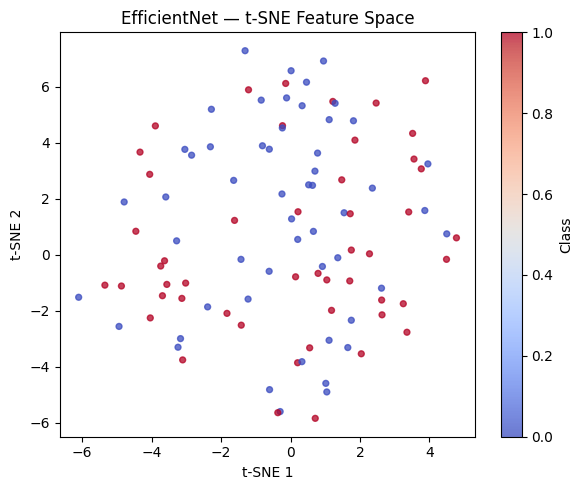

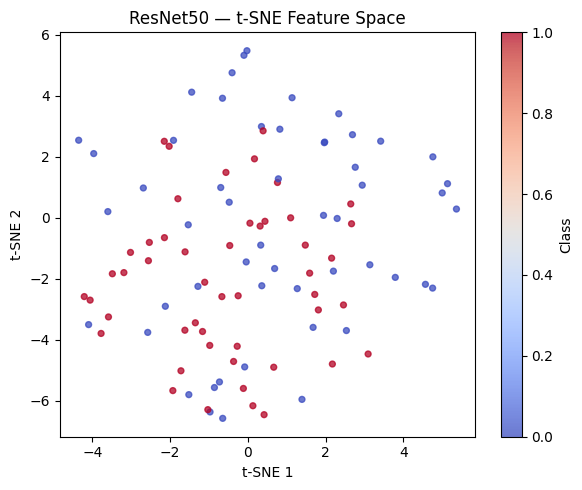

In [48]:
import torch
import numpy as np
import gc
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Embedding extractor
@torch.no_grad()
def get_embeddings(model, loader, device):
    model.eval()
    feats, labels = [], []

    for x, y in loader:
        x = x.to(device)

        if hasattr(model, "forward_features"):
            out = model.forward_features(x)

            if out.ndim == 3:
                emb = out[:, 0]

            elif out.ndim == 4:
                emb = out.mean(dim=(1, 2))

            else:
                raise ValueError(f"Unsupported transformer output: {out.shape}")

        else:
            out = model(x)

            if out.ndim == 4:
                emb = out.mean(dim=(2, 3))
            else:
                emb = out

        feats.append(emb.cpu())
        labels.append(y)

    feats = torch.cat(feats, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    return feats, labels

for name, model in models.items():
    np.random.seed(42)

    idx = np.random.choice(len(val_ds), size=min(400, len(val_ds)), replace=False)
    loader = DataLoader(
        Subset(val_ds, idx),
        batch_size=32,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    feats, labels = get_embeddings(model, loader, device)

    assert feats.ndim == 2, f"{name}: invalid feature shape {feats.shape}"

    feats = StandardScaler().fit_transform(feats)

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        init="pca",
        learning_rate="auto",
        max_iter=1000,
        random_state=42
    )

    reduced = tsne.fit_transform(feats)

    plt.figure(figsize=(6, 5))
    sc = plt.scatter(
        reduced[:, 0],
        reduced[:, 1],
        c=labels,
        cmap="coolwarm",
        alpha=0.75,
        s=18
    )
    plt.title(f"{name} — t-SNE Feature Space")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.colorbar(sc, label="Class")
    plt.tight_layout()
    plt.show()

    plt.close("all")
    torch.cuda.empty_cache()
    gc.collect()